In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib widget

# Abbreviations
OMG — optomiography  
ACC — accelerometer  
GYR — gyroscope  
ENC - encoders (fingers of prosthesis or gloves)  
model — model of data  

# Data

In [2]:
gestures_train = pd.read_csv('gestures_train.csv', index_col=0)

print(gestures_train.shape)
gestures_train.head()

(28976, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,10,8,29,2846,2929,2873,2598,24,8,6,...,32,37,50,54,44,5,0,0,0,1174956
1,10,8,28,2846,2931,2873,2597,24,8,13,...,31,37,50,54,44,5,0,0,0,1174989
2,16,8,29,2847,2930,2875,2598,24,8,6,...,31,37,50,54,44,5,0,0,0,1175022
3,10,8,29,2847,2930,2875,2598,25,8,5,...,30,37,50,54,44,5,0,0,0,1175055
4,0,8,29,2845,2927,2870,2594,24,8,6,...,30,37,50,54,44,5,0,0,0,1175088


In [3]:
# [X features] '0', ..., '49' - каналы OMG датчиков
#              'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
#              'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
# [y target]   'ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5' - координаты пальцев в перчатке GLOVE
# 'BUTTON' - не используется
# 'SYNC' - синхронизация данных с протоколом
# 'ts' - метка времени
gestures_train.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1',
       'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'SYNC', 'ts'],
      dtype='object')

In [4]:
OMG_CH = [str(i) for i in range(50)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
# ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
GLOVE_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']

assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(GLOVE_CH)+len(BUTTON_SYNC_TS_CH) == gestures_train.shape[-1]

print(f"OMG_CH: {list(OMG_CH)}")
print(f"ACC_CH: {list(ACC_CH)}")
print(f"GYR_CH: {list(GYR_CH)}")
print(f"GLOVE_CH: {list(GLOVE_CH)}")
print(f"BUTTON_SYNC_TS_CH: {list(BUTTON_SYNC_TS_CH)}")

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
GLOVE_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']


In [5]:
gestures_test = pd.read_csv('gestures_test.csv', index_col=0)

print(gestures_test.shape)
gestures_test.head()

(7244, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
28976,10,9,38,2994,3119,2996,2773,38,9,6,...,19,25,28,32,17,6,0,0,0,2131164
28977,10,8,35,2989,3117,2996,2766,36,8,6,...,26,25,28,32,17,6,0,0,0,2131197
28978,10,8,32,2983,3113,2993,2763,36,8,5,...,29,25,28,32,17,6,0,0,0,2131230
28979,10,9,37,2986,3113,2992,2763,37,9,6,...,30,25,28,32,17,6,0,0,0,2131263
28980,10,8,36,2987,3115,2993,2762,35,8,6,...,28,25,28,32,17,6,0,0,0,2131296


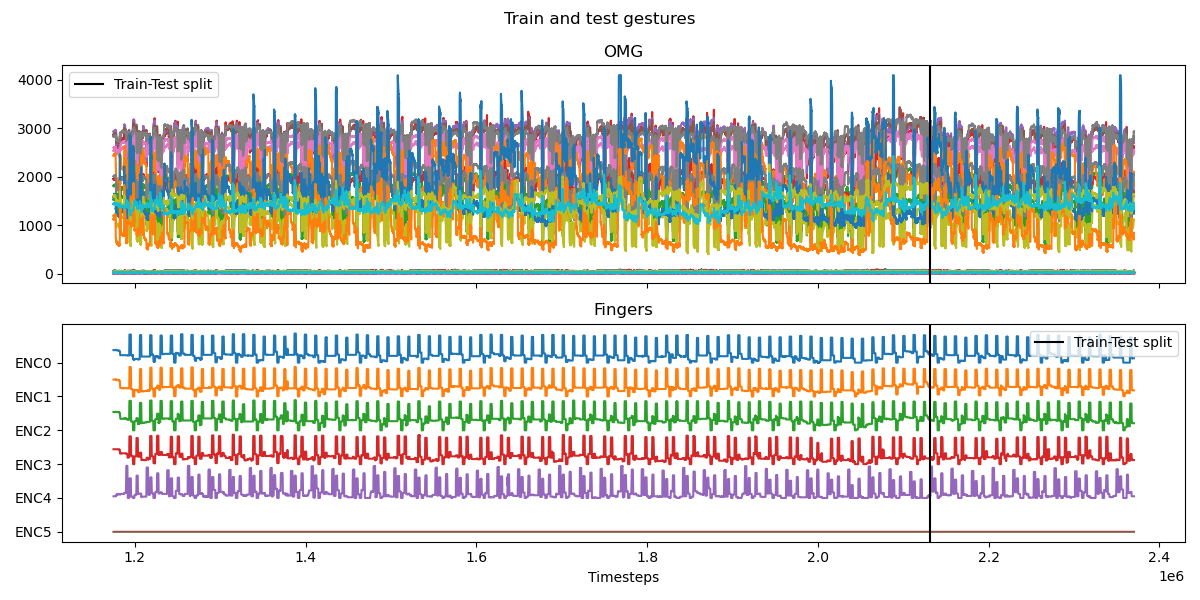

In [6]:
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
plt.sca(axx[0])
plot_train = plt.plot(gestures_train['ts'].values, gestures_train[OMG_CH].values)
plot_test = plt.plot(gestures_test['ts'].values, gestures_test[OMG_CH].values)
for p_train, p_test in zip(plot_train, plot_test):
    p_test.set_color(p_train.get_color())
plt.axvline(gestures_train['ts'].values[-1], color='k', label='Train-Test split')
plt.title('OMG')
plt.legend()

plt.sca(axx[1])
plot_train = plt.plot(gestures_train['ts'].values, gestures_train[GLOVE_CH].values - np.arange(len(GLOVE_CH)) * 100)
plot_test = plt.plot(gestures_test['ts'].values, gestures_test[GLOVE_CH].values - np.arange(len(GLOVE_CH)) * 100)
for p_train, p_test in zip(plot_train, plot_test):
    p_test.set_color(p_train.get_color())
plt.axvline(gestures_train['ts'].values[-1], color='k', label='Train-Test split')
plt.yticks(-np.arange(len(GLOVE_CH)) * 100, GLOVE_CH)
plt.legend()
plt.title('Fingers')
plt.xlabel('Timesteps')

plt.suptitle('Train and test gestures')
plt.tight_layout()

### Protocol

In [7]:
gestures_protocol = pd.read_csv('gestures_protocol.csv')
gestures_protocol.head(10)

,epoch,Thumb,Index,Middle,Ring,Pinky,Thumb_stretch,Index_stretch,Middle_stretch,Ring_stretch,Pinky_stretch,Pronation
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
5,5,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,6,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
8,8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
9,9,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.5


In [8]:
# add OPEN to protocol
mask_open = (gestures_protocol[['Thumb_stretch', 'Index_stretch', 'Middle_stretch', 'Ring_stretch', 'Pinky_stretch']] == 1.0).all(axis=1)
gestures_protocol.loc[mask_open, ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']] = -0.5

In [9]:
gestures_train_ext = pd.merge(
    gestures_train,
    gestures_protocol,
    how='left',
    left_on='SYNC',
    right_on='epoch',
)

gestures_test_ext = pd.merge(
    gestures_test,
    gestures_protocol,
    how='left',
    left_on='SYNC',
    right_on='epoch',
)

In [10]:
gestures_train_ext.isna().sum().unique(), gestures_test_ext.isna().sum().unique()

(array([0], dtype=int64), array([0], dtype=int64))

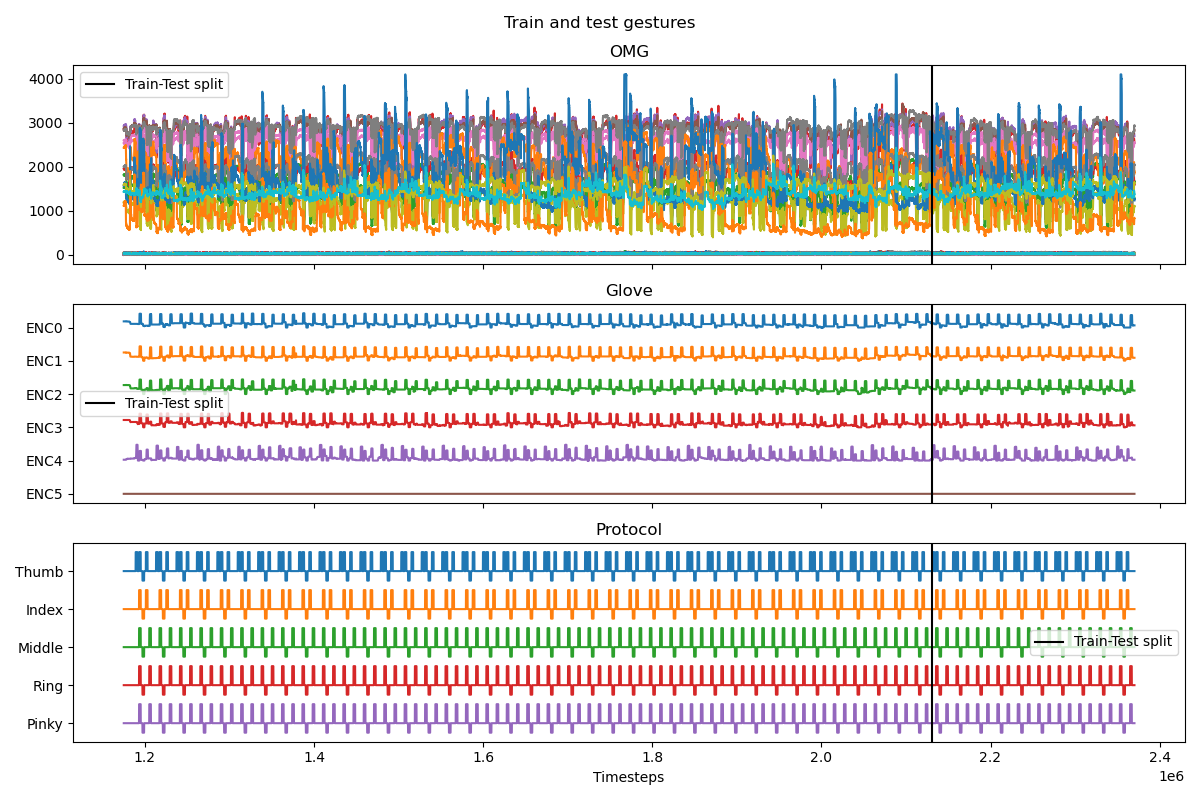

In [11]:
fig, axx = plt.subplots(3, 1, sharex=True, figsize=(12, 8))
plt.sca(axx[0])
plot_train = plt.plot(gestures_train_ext['ts'].values, gestures_train_ext[OMG_CH].values)
plot_test = plt.plot(gestures_test_ext['ts'].values, gestures_test_ext[OMG_CH].values)
for p_train, p_test in zip(plot_train, plot_test):
    p_test.set_color(p_train.get_color())
plt.axvline(gestures_train_ext['ts'].values[-1], color='k', label='Train-Test split')
plt.legend()
plt.title('OMG')

plt.sca(axx[1])
plot_train = plt.plot(gestures_train_ext['ts'].values, gestures_train_ext[GLOVE_CH].values - np.arange(len(GLOVE_CH)) * 200)
plot_test = plt.plot(gestures_test_ext['ts'].values, gestures_test_ext[GLOVE_CH].values - np.arange(len(GLOVE_CH)) * 200)
for p_train, p_test in zip(plot_train, plot_test):
    p_test.set_color(p_train.get_color())
plt.yticks(-np.arange(len(GLOVE_CH)) * 200, GLOVE_CH)
plt.axvline(gestures_train_ext['ts'].values[-1], color='k', label='Train-Test split')
plt.legend()
plt.title('Glove')

plt.sca(axx[2])

plot_train = plt.plot(
    gestures_train_ext['ts'].values,
    gestures_train_ext[['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']].values - np.arange(5) * 2
)

plot_test = plt.plot(
    gestures_test_ext['ts'].values,
    gestures_test_ext[['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']].values - np.arange(5) * 2
)

for p_train, p_test in zip(plot_train, plot_test):
    p_test.set_color(p_train.get_color())
plt.yticks(-np.arange(5) * 2, ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky'])
plt.axvline(gestures_train_ext['ts'].values[-1], color='k', label='Train-Test split')
plt.legend()
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('Train and test gestures')
plt.tight_layout()

# Dataset forming

In [12]:
# # v2 y(t) ~ f[ X(t), y(t-1) ] - это не подойдет для инференса в реальном времени, тк мы будем получать X и y в один момент времени.

# X_train = gestures_train[OMG_CH].values
# y_train = gestures_train[GLOVE_CH].values
# X_train = np.c_[X_train[1:], y_train[:-1]] # coordiantes
# # X_train = np.c_[X_train[1:], gestures_train[GLOVE_CH].diff().fillna(0).values[:-1]] # velocities
# y_train = y_train[1:]

# X_test = gestures_test[OMG_CH].values
# y_test = gestures_test[GLOVE_CH].values
# X_test = np.c_[X_test[1:], y_test[:-1]] # coordiantes
# # X_test = np.c_[X_test[1:], gestures_test[GLOVE_CH].diff().fillna(0).values[:-1]] # velocities
# y_test = y_test[1:]

In [12]:
X_train = gestures_train[OMG_CH].values

In [13]:
X_train.shape

(28976, 50)

In [14]:
X_train[:-1].shape

(28975, 50)

In [15]:
# v2 y(t) ~ f[ X(t-1), y(t-1) ] - это подойдет для инференса в реальном времени

X_train = gestures_train[OMG_CH].values
y_train = gestures_train[GLOVE_CH].values
X_train = np.c_[X_train[:-1], y_train[:-1]]
y_train = y_train[1:]

X_test = gestures_test[OMG_CH].values
y_test = gestures_test[GLOVE_CH].values
X_test = np.c_[X_test[:-1], y_test[:-1]]
y_test = y_test[1:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((28975, 56), (28975, 6), (7243, 56), (7243, 6))

In [16]:
X_train = X_train.astype(float)
X_test  = X_test.astype(float)
y_train = y_train.astype(float)
y_test  = y_test.astype(float)

y_train = pd.DataFrame(y_train, columns=GLOVE_CH, index=gestures_train.index[1:])
y_test  = pd.DataFrame(y_test, columns=GLOVE_CH, index=gestures_test.index[1:])

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((28975, 56), (28975, 6), (7243, 56), (7243, 6))

In [18]:
print((X_train[:, :50]).mean(axis=0))
print((X_train[:, 50:]).mean(axis=0))
print(y_train.values.mean(axis=0))

[   9.44873167    7.58226057   25.22405522 2733.92921484 2764.16262295
 2701.4659189  2446.64241588   23.21553063    7.78098361    5.77987921
    8.01056083   36.66919758 1654.30391717 1750.79906816   43.15409836
   34.35768766 2526.61452977 2792.21601381   26.88365833    5.22712683
   19.22571182 2050.03195858 1373.82778257   43.32900777    9.75333909
    7.14723037   36.01670406 1872.86098361 1079.46771355   13.82170837
 1786.37628991  963.35416739   28.74295082   12.5503365     5.75841242
    4.29366695   10.4888352    49.70367558 1492.84389991 1381.97245902
   33.10377912   27.63130285    9.86533218   10.69839517    7.15509922
    5.25118205    8.21207938   13.48586713   33.42239862   25.90881795]
[25.54578085 30.5495082  35.56148404 27.6656428  21.76686799  0.        ]
[25.5453667  30.54874892 35.56072476 27.66471096 21.7669025   0.        ]


In [16]:
# # scaling
# from sklearn.preprocessing import StandardScaler, MinMaxScaler

# scaler = MinMaxScaler()
# X_train[:, :50] = scaler.fit_transform(X_train[:, :50])
# X_test[:, :50] = scaler.transform(X_test[:, :50])

# X_train[:, 50:] = X_train[:, 50:] / 100
# X_test[:, 50:] = X_test[:, 50:] / 100

# y_train = y_train / 100
# y_test = y_test / 100

In [19]:
print((X_train[:, :50]).mean(axis=0))
print((X_train[:, 50:]).mean(axis=0))
print(y_train.values.mean(axis=0))

[   9.44873167    7.58226057   25.22405522 2733.92921484 2764.16262295
 2701.4659189  2446.64241588   23.21553063    7.78098361    5.77987921
    8.01056083   36.66919758 1654.30391717 1750.79906816   43.15409836
   34.35768766 2526.61452977 2792.21601381   26.88365833    5.22712683
   19.22571182 2050.03195858 1373.82778257   43.32900777    9.75333909
    7.14723037   36.01670406 1872.86098361 1079.46771355   13.82170837
 1786.37628991  963.35416739   28.74295082   12.5503365     5.75841242
    4.29366695   10.4888352    49.70367558 1492.84389991 1381.97245902
   33.10377912   27.63130285    9.86533218   10.69839517    7.15509922
    5.25118205    8.21207938   13.48586713   33.42239862   25.90881795]
[25.54578085 30.5495082  35.56148404 27.6656428  21.76686799  0.        ]
[25.5453667  30.54874892 35.56072476 27.66471096 21.7669025   0.        ]


# Modeling

In [20]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

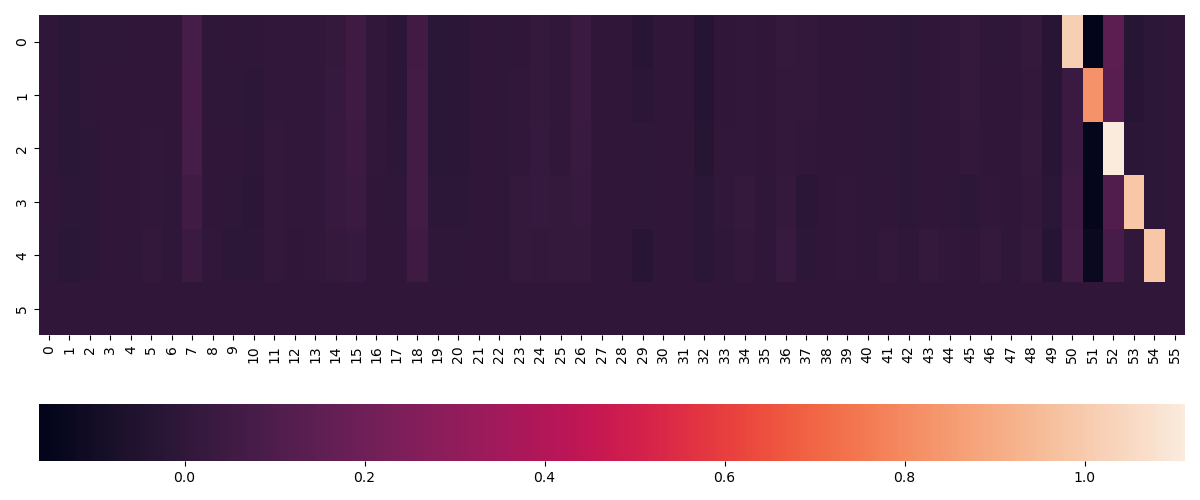

In [21]:
import seaborn as sns

plt.figure(figsize=(12, 5))
# IMPORTANT: "подсветились" именно авторегрессионные таргет-признаки
#            поэтому высокий риск вырождения модели в предсказание предыдущего значения таргета,
#            которое прихордит на вход в качестве признака
sns.heatmap(model.coef_, cbar_kws={"orientation": "horizontal"})
plt.tight_layout()

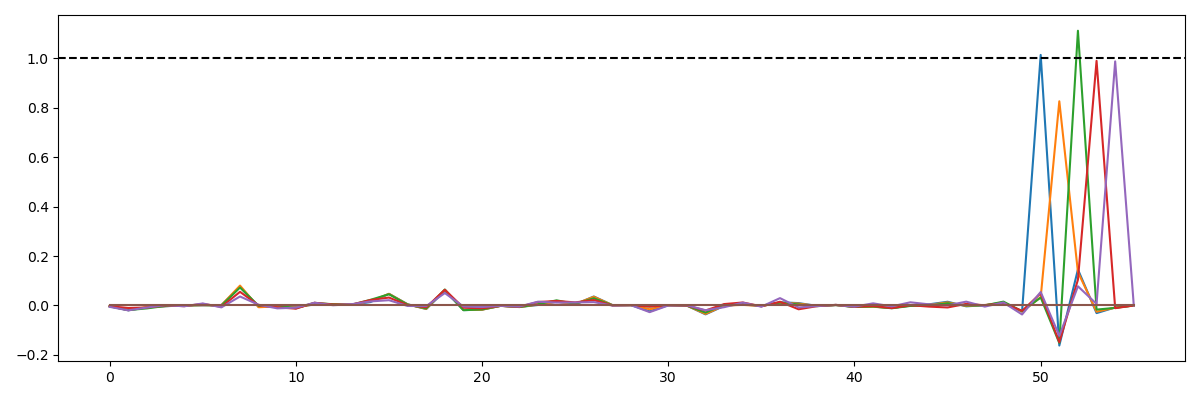

In [22]:
# IMPORTANT:
#   - данный график отражает веса признаков в моделях
#   - в основном веса примерно равны нулю, кроме последних пиков справа
#   - пики справа - это как раз авторегрессионные таргет-признаки
#   - видно, что веса этих признаков примерно равны 1
#   - это означает, что модель предсказывает предыдущее значение таргета
plt.figure(figsize=(12, 4))
plt.plot(model.coef_.T)
plt.axhline(1, color='k', linestyle='--')
plt.tight_layout()

## Prediction

In [23]:
# classic prediction
y_pred_train = model.predict(X_train)
y_pred_train = pd.DataFrame(y_pred_train, columns=GLOVE_CH, index=gestures_train.index[1:])

y_pred_test = model.predict(X_test)
y_pred_test = pd.DataFrame(y_pred_test, columns=GLOVE_CH, index=gestures_test.index[1:])

In [22]:
# # refeed prediction
# y_pred_train = np.zeros_like(y_train)
# y_pred_prev = np.zeros((1, len(GLOVE_CH)))
# for i in range(len(y_train)):
#     X_cur = np.c_[X_train[[i], : -len(GLOVE_CH)], y_pred_prev]
#     y_pred_train[i] = model.predict(X_cur)
#     y_pred_prev = y_pred_train[[i]].copy()

# y_pred_test = np.zeros_like(y_test)
# y_pred_prev = np.zeros((1, len(GLOVE_CH)))
# for i in range(len(y_test)):
#     X_cur = np.c_[X_test[[i], : -len(GLOVE_CH)], y_pred_prev]
#     y_pred_test[i] = model.predict(X_cur)
#     y_pred_prev = y_pred_test[[i]].copy()

# y_pred_train = pd.DataFrame(y_pred_train, columns=GLOVE_CH, index=gestures_train.index[1:])
# y_pred_test = pd.DataFrame(y_pred_test, columns=GLOVE_CH, index=gestures_test.index[1:])

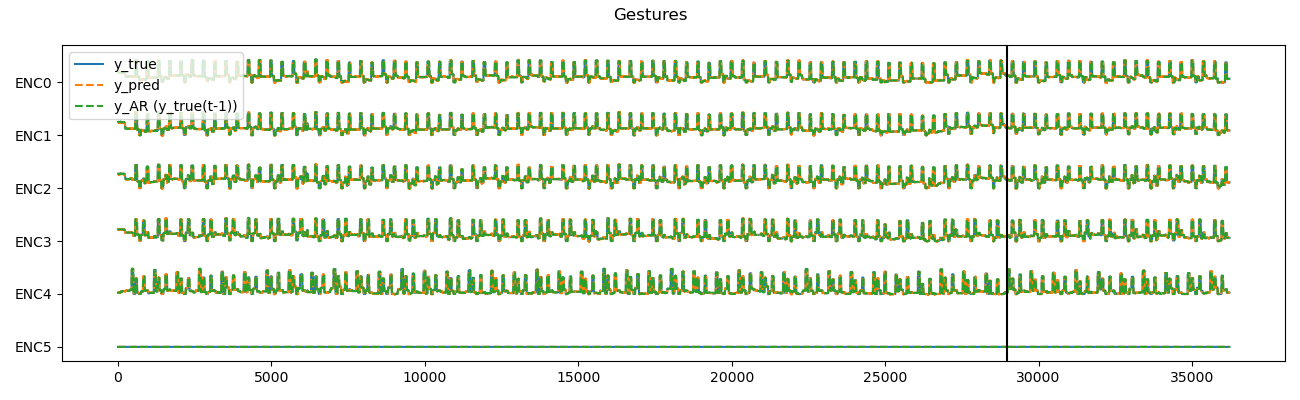

In [24]:
fig, axes = plt.subplots(1, 1, figsize=(13, 4))

plt.sca(axes)
lines = []
labels = []
yticks = -np.arange(len(GLOVE_CH)) * 200

p = plt.plot(y_train.index, y_train + yticks, c='C0')
plt.plot(y_test.index, y_test + yticks, c='C0')
lines += [p[0]]
labels += ['y_true']

p = plt.plot(y_pred_train.index, y_pred_train.values + yticks, c='C1', linestyle='--')
plt.plot(y_pred_test.index, y_pred_test.values + yticks, c='C1', linestyle='--')
lines += [p[0]]
labels += ['y_pred']

p = plt.plot(y_pred_train.index, X_train[:, -len(GLOVE_CH):] + yticks, c='C2', linestyle='--')
plt.plot(y_pred_test.index, X_test[:, -len(GLOVE_CH):] + yticks, c='C2', linestyle='--')
lines += [p[0]]
labels += ['y_AR (y_true(t-1))']

plt.axvline(len(y_train), color='k')

plt.yticks(yticks, GLOVE_CH)
plt.legend(lines, labels, loc='upper left')
plt.suptitle(f'Gestures')
plt.tight_layout()

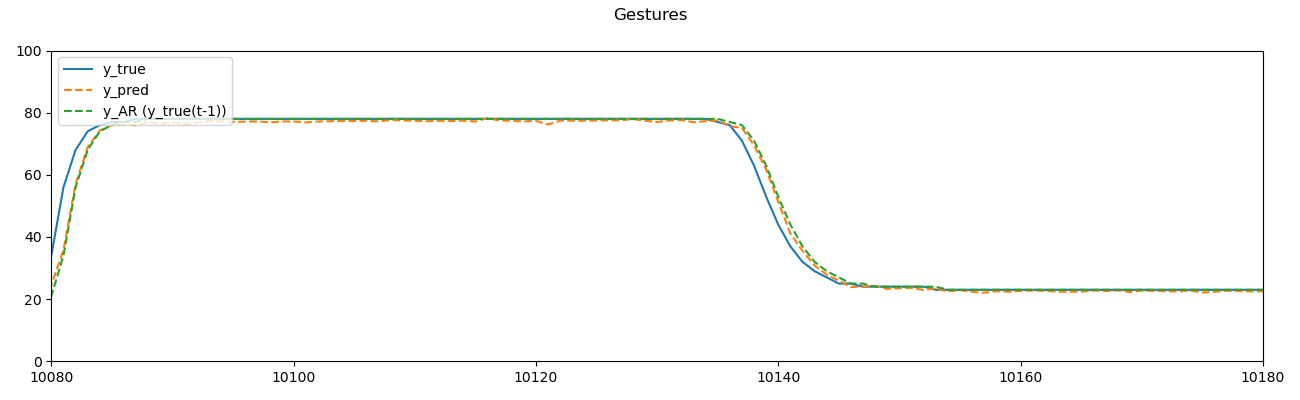

In [25]:
fig, axes = plt.subplots(1, 1, figsize=(13, 4))

plt.sca(axes)
lines = []
labels = []
yticks = -np.arange(len(GLOVE_CH)) * 200

p = plt.plot(y_train.index, y_train + yticks, c='C0')
plt.plot(y_test.index, y_test + yticks, c='C0')
lines += [p[0]]
labels += ['y_true']

p = plt.plot(y_pred_train.index, y_pred_train.values + yticks, c='C1', linestyle='--')
plt.plot(y_pred_test.index, y_pred_test.values + yticks, c='C1', linestyle='--')
lines += [p[0]]
labels += ['y_pred']

p = plt.plot(y_pred_train.index, X_train[:, -len(GLOVE_CH):] + yticks, c='C2', linestyle='--')
plt.plot(y_pred_test.index, X_test[:, -len(GLOVE_CH):] + yticks, c='C2', linestyle='--')
lines += [p[0]]
labels += ['y_AR (y_true(t-1))']

plt.axvline(len(y_train), color='k')

plt.xlim(10080, 10180)
plt.ylim(0, 100)

plt.legend(lines, labels, loc='upper left')
plt.suptitle(f'Gestures')
plt.tight_layout()

## Metrics

In [26]:
from sklearn.metrics import mean_squared_error as mse

metrics_train = {col : mse(y_train[col], y_pred_train[col]) for col in GLOVE_CH}
metrics_test  = {col : mse(y_test[col],  y_pred_test[col])  for col in GLOVE_CH}

metrics_train = pd.Series(metrics_train)
metrics_test = pd.Series(metrics_test)

print('Train')
display(metrics_train)
print('Test')
display(metrics_test)

Train


ENC0    3.637749
ENC1    3.320280
ENC2    3.411175
ENC3    3.781513
ENC4    5.326050
ENC5    0.000000
dtype: float64

Test


ENC0    3.904033
ENC1    3.119769
ENC2    3.480137
ENC3    3.987056
ENC4    4.784909
ENC5    0.000000
dtype: float64

# Real-time inference

In [26]:
import time
import serial
from IPython.display import clear_output

In [27]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

## Inference Utils: Put your code here

In [28]:
def preprocessing(x):
    # x - sample vector
    y = x
    return y

def inference(x):
    y = model.predict([x])[0] 
    return y

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*0.1 + prev*0.9 # Holt-Winters filter
    return y

def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y

## Inference

### Offline (dataset)

In [29]:
df_sim = gestures_test.copy()
# df_sim = free_movements.iloc[:10000]
print(df_sim.shape)

(5330, 65)


In [30]:
TIMEOUT = 0.033
DEBUG = True
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_predicted = np.zeros(6)
y_previous = None
y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}
while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    # classic prediction
    y_predicted         = inference(np.r_[sample_preprocessed, enc_sample])
    # refeed prediction
    # y_predicted         = inference(np.r_[sample_preprocessed, y_predicted])
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

SAMPLE SIZE: 65, OMG: 50, ACC: 6, ENCODERS: 6
BUTTON: 0, SYNC: 0, TS: 1041207
[54 53 59 31 28  0]


In [31]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (5330, 50)
enc_sample.shape = (5330, 6)
sample_preprocessed.shape = (5330, 50)
y_predicted.shape = (5330, 6)
y_postprocessed.shape = (5330, 6)
y_commands.shape = (5330, 6)


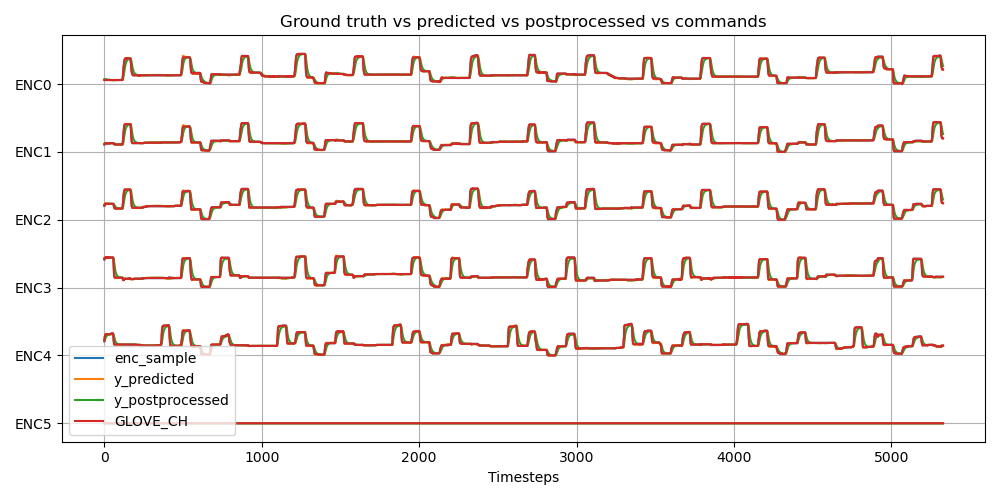

In [32]:
fig = plt.figure(figsize=(10, 5))

lines = []
labels = []
yticks = -np.arange(len(GLOVE_CH)) * 200

plots = plt.plot(y_dct['enc_sample'] + yticks, c='C0')
lines += [plots[0]]
labels += ['enc_sample']

plots = plt.plot(y_dct['y_predicted'] + yticks, c='C1')
lines += [plots[0]]
labels += ['y_predicted']

plots = plt.plot(y_dct['y_postprocessed'] + yticks, c='C2')
lines += [plots[0]]
labels += ['y_postprocessed']

# plots = plt.plot(y_dct['y_commands'] + yticks, c='C3')
# lines += [plots[0]]
# labels += ['y_commands']

plots = plt.plot(df_sim[GLOVE_CH].values[1:] + yticks, c='C3') # shift by 1 timestep forward
lines += [plots[0]]
labels += ['GLOVE_CH']

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(yticks, GLOVE_CH)
plt.legend(lines, labels)
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

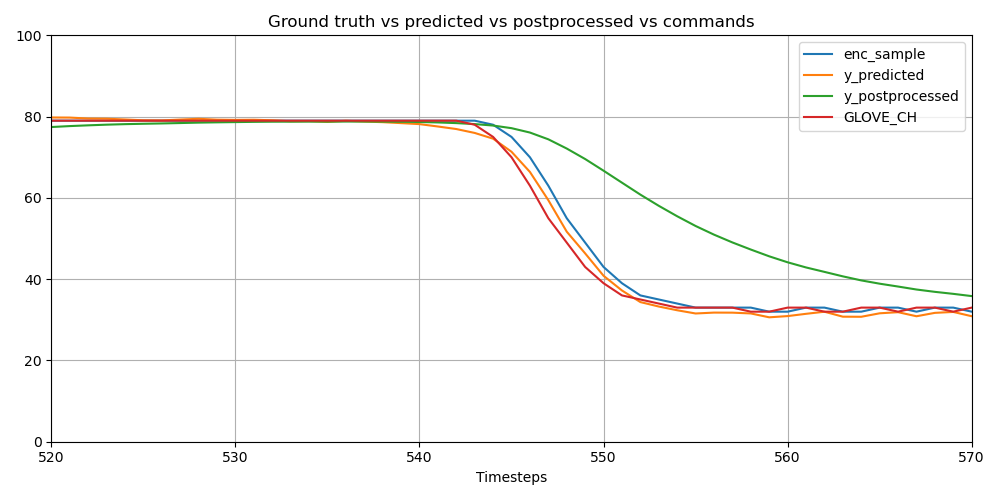

In [33]:
fig = plt.figure(figsize=(10, 5))

lines = []
labels = []
yticks = -np.arange(len(GLOVE_CH)) * 200

plots = plt.plot(y_dct['enc_sample'] + yticks, c='C0')
lines += [plots[0]]
labels += ['enc_sample']

plots = plt.plot(y_dct['y_predicted'] + yticks, c='C1')
lines += [plots[0]]
labels += ['y_predicted']

plots = plt.plot(y_dct['y_postprocessed'] + yticks, c='C2')
lines += [plots[0]]
labels += ['y_postprocessed']

# plots = plt.plot(y_dct['y_commands'] + yticks, c='C3')
# lines += [plots[0]]
# labels += ['y_commands']

plots = plt.plot(df_sim[GLOVE_CH].values[1:] + yticks, c='C3') # shift by 1 timestep forward
lines += [plots[0]]
labels += ['GLOVE_CH']

plt.xlim(520, 570)
plt.ylim(0, 100)

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.legend(lines, labels)
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

### Online (prosthesis or virtual hand)

In [ ]:
TIMEOUT = 0.033
DEBUG = True

ser = None
# ser_port = None
ser_port = '/dev/cu.usbmodem3498365F31351'

if ser_port is not None:
    ser = serial.Serial(port=ser_port, timeout=2*TIMEOUT)
    ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
    ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
    ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check

    # flush buffers
    ser.reset_input_buffer()
    ser.read()
    
    i = 0;
    while(ser.in_waiting):
        print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
        ser.read_all()
        time.sleep(0.005)
        i+=1;
    ser.readline()
    ser.readline()
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
while True:    
    
    # [Data reading]
    s = ser.readline()
    ts_start = time.time()
    
    try:
        sample = np.array(s.decode('UTF-8')\
                           .replace('\r\n', "")\
                           .split(' ')
                         ).astype(int)
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
    # [/Commands sending]
    
    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
        print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
        print('INPUT:\n', s)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
        print(pack)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 